<a href="https://colab.research.google.com/github/dong-gi-jang/binfo/blob/main/Free%201/Free1_Fig5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free 1
## LIN28A is a suppressor of ER-associated translation in embryonic stem cells
[위 논문](https://doi.org/10.1016/j.cell.2012.10.019)의 Fig.5A (GO enrichment analysis) 재현하기

In [4]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요 툴 설치
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

!conda install -y subread

Subread featurecounts이용한 transcript별 read count 계산.

multi-mapping도 고려해야 하는가?
 - ignore all : transcript level에서는 이건 안됨? complete exons would be ignored.[[1]](https://www.sciencedirect.com/science/article/pii/S2001037020303032)
   - 그런데 기존 week1 read-counts.txt 파일은 gene level에서, 이렇게?
 - count once per alignment (-M)
 - equally split (-M --fraction)
   - 그러나 truly expressed gene을 underestimate할 가능성

In [6]:
%cd /content/drive/MyDrive/binfo1-datapack1/

# to equally split,
# !featureCounts -a gencode.gtf -o read-counts_es.txt -M --fraction *.bam 

# to ignore,
# !featureCounts -a gencode.gtf -o read-counts.txt *.bam 

/content/drive/MyDrive/binfo1-datapack1


In [7]:
# 그런데 우선은 ignore 결과인 기존 week1 read-counts.txt 파일 가져와서 진행.
import pandas as pd
import numpy as np
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

In [14]:
# 각 컬럼의 sum (total assigned read count)으로 normalize해도 되는가.
# bam파일 자체에서의 align reads 수로 normalize 해야 하나.

#일단은 featurecounts 결과에서의 각 column의 total sum으로 normalize가 문제없다면 시도해보자.
cnts['log2_clip_enrichment'] = np.log2(   (cnts['CLIP-35L33G.bam']/cnts['CLIP-35L33G.bam'].sum() ) / (cnts['RNA-control.bam']/cnts['RNA-control.bam'].sum() ) )
cnts['log2_rden_change'] = np.log2( (   (cnts['RPF-siLin28a.bam']/cnts['RPF-siLin28a.bam'].sum()) / (cnts['RNA-siLin28a.bam']/cnts['RNA-siLin28a.bam'].sum() ) / ( (cnts['RPF-siLuc.bam']/cnts['RPF-siLin28a.bam'].sum() )/ (cnts['RNA-siLuc.bam']/cnts['RNA-siLuc.bam'].sum()))))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
# Geneid(index) 마다 있는 점 뒤쪽 제거하여 우선은 gene level에서 보기
import copy

cnts_rmdot = copy.deepcopy(cnts)
cnts_rmdot.index = cnts_rmdot.index.map(lambda p : p.split('.')[0])
cnts_rmdot.head()

,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,clip_enrichment,rden_change,log2_clip_enrichment,log2_rden_change
Geneid,,,,,,,,,,,,,,,
ENSMUSG00000102693,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,NaN,NaN,NaN,NaN
ENSMUSG00000064842,chr1,3172239,3172348,+,110,0,0,0,0,0,0,NaN,NaN,NaN,NaN
ENSMUSG00000051951,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,4,1,1,1,0,0,0.60993,NaN,0.60993,NaN
ENSMUSG00000102851,chr1,3322980,3323459,+,480,3,0,0,0,0,0,inf,NaN,inf,NaN
ENSMUSG00000103377,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [16]:
# cutoff 정해 low abundant 제거하기
# 논문 따라하려면 ?
rna_cutoff = 30
ribo_cutoff = 80

ribobool = cnts_rmdot['RPF-siLuc.bam'] > ribo_cutoff
rnabool = cnts_rmdot['RNA-siLuc.bam'] > rna_cutoff
lin28abool = cnts_rmdot['RNA-siLin28a.bam'] > rna_cutoff
clipbool = cnts_rmdot['RNA-control.bam'] > rna_cutoff
cnts_cutoff = cnts_rmdot[ribobool & rnabool & lin28abool & clipbool]
# 아니면 cnts_cutoff = cnts_rmdot[ribobool & rnabool] 까지만.

cnts_cutoff

,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,clip_enrichment,rden_change,log2_clip_enrichment,log2_rden_change
Geneid,,,,,,,,,,,,,,,
ENSMUSG00000033845,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4843429;4843434;4844659;4846600;4847748;484774...,4844739;4847024;4844739;4847024;4847871;484787...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,8487,4014,1355,3022,2563,1859,3191,0.176678,-0.677305,0.176678,-0.677305
ENSMUSG00000033813,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4928037;4928261;4937693;4937693;4948250;494825...,4928199;4928726;4937755;4937755;4948355;494835...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,3017,1658,762,2130,2225,328,609,-0.268489,-0.489948,-0.268489,-0.489948
ENSMUSG00000033793,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,5140241;5153303;5153333;5153347;5153355;515335...,5140367;5153501;5153848;5153501;5153501;515350...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,9746,1111,474,1260,1031,603,1128,-0.161170,-0.853070,-0.161170,-0.853070
ENSMUSG00000025907,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,6276421;6276451;6284869;6284887;6285232;629382...,6276494;6276494;6285181;6285181;6285476;629396...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,14690,1520,280,694,903,132,251,1.050502,-0.207512,1.050502,-0.207512
ENSMUSG00000051285,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,7159144;7159154;7159328;7159390;7190418;721786...,7159440;7159440;7159440;7159440;7190839;721796...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,6654,3508,529,2360,1775,208,138,1.339239,0.520794,1.339239,0.520794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064358,chrM,8607,9390,+,784,6,56,86,50,72,94,-4.612463,-0.827226,-4.612463,-0.827226
ENSMUSG00000064363,chrM,10167,11544,+,1378,373,2150,5028,4224,3292,2498,-3.917159,0.486663,-3.917159,0.486663
ENSMUSG00000064367,chrM,11742,13565,+,1824,3665,5281,15549,17408,5986,5305,-1.917068,0.677015,-1.917068,0.677015


In [ ]:
# t-test 대신 Mann-Whitney U test(Wilcoxon ranksum) 이용?
# log2 fc of ribosome density에 대한 test.
# rank 기반, 정규성 필요x

In [ ]:
# EnsEMBL Gene ID를 gene symbol 또는 다른 identifier로 바꿔줘야 할 필요성?
!pip install gseapy
import gseapy as gp

In [ ]:
bm = gp.parser.Biomart()

In [ ]:
result = bm.query(dataset='hsapiens_gene_ensembl',attributes=['ensembl_gene_id','external_gene_name'],filters={'ensembl_gene_id':뽑은geneid변수명})
upreg_genenames = result['external_gene_name'].dropna().drop_duplicates().tolist()


In [45]:
# GO database 가져오기
humanlib = gp.get_library_name(organism='Human')
humangolib = [s for s in humanlib if "GO" in s] 
humangolib2021 = [s for s in humangolib if "2021" in s]
humangolib2021

['GO_Biological_Process_2021',
 'GO_Cellular_Component_2021',
 'GO_Molecular_Function_2021']

In [ ]:
enr= gp.enrichr(gene_list = upreg_genenames, gene_sets=humangolib2021,organism='Human',description='',outdir='test/enrichr_go2021',cutoff=0.05)

# 비슷한 term 뭉쳐주는 clustering은 g:profiler 등으로 시도해보자.

RuntimeError: ignored

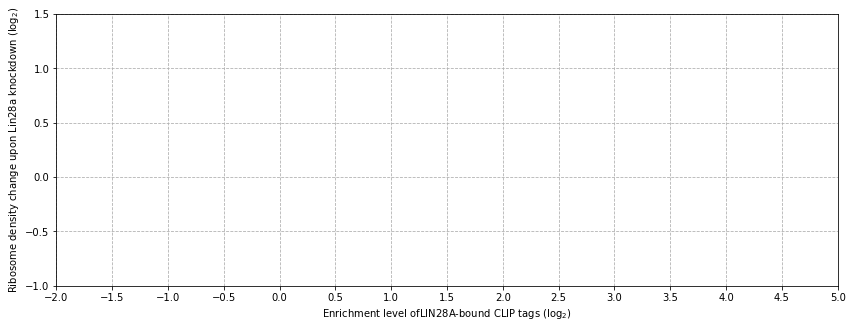

In [35]:
# visulaize

# 우선 최대한 파이썬의 scatter(bubble plot) 등으로 표현해보기
# 각 bubble 주변에 label(말풍선 및 화살표) 적절히 놓을 수 있는 방법? 
# plt fig ax, subplot 사용?

from matplotlib import pyplot as plt
plt.figure(figsize=(14,5))
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)')
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)')
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5))
plt.yticks(np.arange(-1, 1.51, step=0.5))
plt.grid(True, linestyle='--')
clb=plt.colorbar()
clb.ax.tick_params(tick=0.1,labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.plot()